# Comparison in cancer

We compare here the performances of the various factorization methods on multi-omics cancer datasets. The methods are evaluated regarding associations to clinical annotation, survival, and biological annotations (GO, REACTOME, Hallmarks).

## Comparison based on clinical annotations

We define here a function that computes the number of clinical annotations significantly associated with at least one factor, and their selectivity.  The selectivity is defined as the ratio between the number of unique clinical annotations significantly associated with a factor and the number of total (factor,clinical annotation) associations. The clinical metadata need to be stored in a clinical folder containing files named according to each cancer type. 

In [1]:
## Perform clinical annotation-based comparison 
## INPUTS:
# factorizations = already computed factirizations
# clinical = clinical information associated with samples
# col = columns in clinical data on which the analysis will be performed
## OUPUTS: a list containing output values
# selectivity = Selectivity (fraction of significant annotations per all significant factors)
# nnzero = Number of unique factors that were significant at least once
# num.enriched = Number of clinical annotations with at least one significant factor component
clinical_comparison <- function(factorizations, clinical, col){

    # Empty containers
    line <- numeric(0)
    line2 <- numeric(0)
    line3 <- numeric(0)

    # For each factorization
    for(i in 1:length(factorizations)){

        # Extract sample association
        factors <- factorizations[[i]][[1]]
        if(is.null(names(factors))) { names(factors) <- 1:ncol(factors) }
        if(is.null(colnames(factors))) { colnames(factors) <- 1:ncol(factors) }

        # Patient names in factorisation results
        patient.names <- rownames(factors)
        # Patient names in original data
        patient.names.in.file <- as.character(clinical[, 1])
        patient.names.in.file <- toupper(gsub('-', '\\.', patient.names.in.file))
        # Remove non-matching patient names
        is_in_file <- patient.names %in% patient.names.in.file
        if(length(patient.names)!=sum(is_in_file)) {
            factors <- factors[is_in_file, ]
            patient.names <- patient.names[is_in_file]
            rownames(factors)<-patient.names
        }
        # Match indices of patient names
        indices <- match(patient.names, patient.names.in.file)
        # Use indices to extract coresponding survival information
        ordered.clinical.data <- clinical[indices,]        
        
        # Only use column names that are really present in the data
        col_new <- col[col %in% colnames(ordered.clinical.data)]

        # Stor all p-values
        pvalues <- numeric(0)
        # Store number of significant annotations
        clin_erich <- 0 
        
        # Test significance association with clinical annotations
        for(j in col_new){
            
            # Perform the analysis if there is more than one possible value in current column
            table_values <- table(ordered.clinical.data[,j])
            if(sum(table_values>0)>1){

                if(j == "age_at_initial_pathologic_diagnosis" ){
                    pvalues_col <- apply(factors, MARGIN=2, 
                                       function(x) kruskal.test(x~cut(as.numeric(ordered.clinical.data[,j]),
                                                                      5, include.lowest=TRUE))$p.value)
                    pvalues <- c(pvalues, pvalues_col)
                    if(min(pvalues_col)<0.05){
                        clin_erich <- clin_erich+1
                    }
                }else if(j == "days_to_new_tumor_event_after_initial_treatment"){
                    pvalues_col <- apply(factors,MARGIN=2, 
                                       function(x) kruskal.test(x~cut(as.numeric(ordered.clinical.data[,j]), 
                                                                      3, include.lowest=TRUE))$p.value)
                    pvalues <- c(pvalues, pvalues_col)
                    if(min(pvalues_col)<0.05){
                        clin_erich <- clin_erich+1
                    }
                }else if(j == "gender" || j == "history_of_neoadjuvant_treatment"){
                    pvalues_col <- apply(factors, MARGIN=2, 
                                       function(x) wilcox.test(x~ordered.clinical.data[,j])$p.value)
                    pvalues <- c(pvalues, pvalues_col)
                    if(min(pvalues_col)<0.05){
                        clin_erich <- clin_erich+1
                    }
                }
            }
        }
        
        # Number of clinical annotations with at least one significant p-value
        line3 <- rbind(line3, clin_erich)

        # Total number of significant factors in all tested columns
        column <- names(pvalues)[pvalues<0.05]
        # Number of unique factors that were significant at least once
        line2<-rbind(line2, length(unique(column)))

        # Number of times a p-value was found significant
        signif <- length(column)
                                         
        # Selectivity (fraction of significant annotations per all significant factors)
        if(signif!=0){
            line <- rbind(line,clin_erich/signif)
        }else{
            line <- rbind(line,0)
        }

    }
    
    # Store and return results
    out <- data.frame(selectivity=line, nnzero=line2, num.enriched=line3)
    print(out)
    return(out)
}

## Comparison based on survival predictions

We define here the function testing significant associations of factors to survival.

In [2]:
library('survival')

## Perform survival annotation-based comparison 
## INPUTS:
# factorizations = already computed factirizations
# method = methods used for factorization
# survival = survival data associated to the cancer
# out.folder = folder where results will be written
# cancer = name of currently analysed cancer
## OUPUTS: a list containing output values
survival_comparison <- function(factorizations, method, survival, out.folder, cancer){
    
    # Initialize result containers
    factors_cancer <- numeric(0)
    surv_final <- numeric(0)
    
    # For each computed factorisation
    for(i in 1:length(factorizations)){

        # Extract sample factors 
        factors <- factorizations[[i]][[1]]

        # Patient names in factorisation results
        patient.names <- rownames(factors)
        # Patient names in original data
        patient.names.in.file <- as.character(survival[, 1])
        patient.names.in.file <- toupper(gsub('-', '\\.', patient.names.in.file))
        # Remove non-matching patient names
        is_in_file <- patient.names %in% patient.names.in.file
        if(length(patient.names)!=sum(is_in_file)) {
            factors <- factors[is_in_file, ]
            patient.names <- patient.names[is_in_file]
            rownames(factors)<-patient.names
        }
        # Match indices of patient names
        indices <- match(patient.names, patient.names.in.file)
        # Use indices to extract coresponding survival information
        ordered.survival.data <- survival[indices,]
        # Clean data (assign 0 to NAs)
        ordered.survival.data$Survival[is.na(ordered.survival.data$Survival)] <- 0
        ordered.survival.data$Death[is.na(ordered.survival.data$Death)] <- 0

        # Calculate coxph
        coxph_obj <- coxph(Surv(ordered.survival.data$Survival, ordered.survival.data$Death) ~ factors)
        # P-values (corrected by the number of methods)
        pvalues <- length(factorizations)*as.matrix(coef(summary(coxph_obj))[,5])

        # How many significant? 
        factors_cancer <- c(factors_cancer, sum(pvalues<0.05))
        # Store p-values
        surv_final <- cbind(surv_final, pvalues) 
    }
    # Keep -log10 of p-values
    surv_final<-(-log10(surv_final))
    # Plot survival pvalues for each cancer type separately
    png(file=paste0(out.folder, "survival_", cancer, ".png"), width = 15, height = 15, units = 'in', res = 200)
    matplot(1:length(method), t(surv_final), 
            col="black", pch=18, xlab="Method", ylab="Pvalues survival", xaxt="none", cex=1.5)
    abline(h = (-log10(0.05)), v=0, col="black", lty=3, lwd=3)
    axis(1, at=1:length(method), labels=colnames(surv_final)) 
    dev.off()

    print(factors_cancer)
    return(factors_cancer)
}

## Comparison based on association to biological annotations (REACTOME, Hallmarks, GO)

In [3]:
library("fgsea", quietly = TRUE)

## Perform biological annotation-based comparison 
## INPUTS:
# factorizations = already computed factirizations
# path.database = path to a GMT annotation file
# pval.thr = p-value threshold (default to 0.05)
## OUPUTS: a list containing output values
biological_comparison <- function(factorizations, path.database, pval.thr=0.05){
    
    # Load annotation database
    pathways <- gmtPathways(path.database)
    
    # Containers to report results
    report_number <- numeric(0)
    report_nnzero <- numeric(0)
    report_select <- numeric(0)
    
    # For each factorization method
    for(i in 1:length(factorizations)){
        
        # Extract metagenes found by factorization method
        metagenes<-factorizations[[i]][[2]][[1]]
        # Number of factors
        num.factors <- ncol(metagenes)
        # Rename columns
        colnames(metagenes)<-1:num.factors
        # Rename rows to remove "|" characters and keep only the gene name before
        rownames(metagenes)<-gsub("\\|",".",rownames(metagenes))
        rownames(metagenes)<-gsub("\\..*","",rownames(metagenes))
        # Remove duplicated gene names that could confuse fgsea
        duplicated_names <- unique(rownames(metagenes)[duplicated(rownames(metagenes))])
        metagenes <- metagenes[!(rownames(metagenes) %in% duplicated_names), ]
        # Variables
        col2 <- numeric(0)
        path <- numeric(0)
        n <- 0
        
        # Calculate biological annotation enrichment.
        # For each factor,
        for(j in 1:num.factors){
            # Assign gene names
            rnk <- setNames(as.matrix(metagenes[,j]), rownames(metagenes))
            # Compute fgsea
            fgseaRes <- fgsea(pathways, rnk, minSize=15, maxSize=500, nperm=1000)
            # If at least one pathway is significant
            if(sum(fgseaRes$padj < pval.thr)!=0){
                # Count this factor
                n <- n+1
                # Keep min adjusted p-value
                col2 <- rbind(col2, min(fgseaRes$padj))
                # Keep names of significant pathways
                path <- c(path, fgseaRes[fgseaRes$padj<pval.thr, "pathway"])
            } else {
                col2 <- rbind(col2, NA)
            }
        }

        # Report number of unique significant pathways  
        if(length(path)==0){
            report_number <- rbind(report_number, 0)
        }else{
            report_number <- rbind(report_number, length(unique(path)))
        }
        # Report selectivity (nb unique significant pathways / total nb pathways)
        if(length(unique(path))==0){
            report_select <- rbind(report_select, NA)
        }else{
            report_select <- rbind(report_select, length(path)/(length(unique(path))))
        }
        # Report number of factors associated with at least one significant pathway
        report_nnzero<-rbind(report_nnzero, n)    
    
    }
    
    out <- data.frame(selectivity=report_select, nnzero=report_nnzero, num.enriched=report_number)
    print(out)
    return(out)
}

## Running the comparisons in cancer

The cancer data should be organized into the data folder, each of them having the name of a different cancer type and containin the various omics data (3 omics for our test cases).

In [4]:
# Load the function running the factorization, plus a support function
source("runfactorization.R")
source("log2matrix.R")

# List downloaded cancer data.
# Folder structure should be organized as discussed above.
# Exclude first result as it's the parent folder
cancers <- list.dirs(path = "../data/cancer", full.names = TRUE, recursive = TRUE)[-1]
cancer_names <- list.dirs(path = "../data/cancer", full.names = FALSE, recursive = TRUE)[-1]

# Annotation databases used for biological enrichment
path.database <- "../data/bio_annotations/c2.cp.reactome.v6.2.symbols.gmt" #REACTOME
#path.database <- "../data/bio_annotations/h.all.v6.2.symbols.gmt" #Hallmarks
#path.database <- "../data/bio_annotations/c5.all.v6.2.symbols.gmt" #GO

# Label to identify current run
tag <- format(Sys.time(), "%Y%m%d%H%M%S")
# Folder for comparison results
results_folder <- paste0("../results", tag, "/")
# Create output folder
dir.create(results_folder, showWarnings = FALSE)

# Number of factors used in the paper
num.factors <- 10

# Initialize result containers
clinical_selectivity <- list()
clinical_nnzero <- list()
clinical_num.enriched <- list()
bio_selectivity <- list()
bio_nnzero <- list()
bio_num.enriched <- list()
cancer.list <- list()

# Clinical categories to be used for clinical tests
col <- c("age_at_initial_pathologic_diagnosis",
         "gender",
         "days_to_new_tumor_event_after_initial_treatment",
         "history_of_neoadjuvant_treatment")

Loading required package: MASS
Loading required package: NMF
Loading required package: pkgmaker
Loading required package: registry

Attaching package: ‘pkgmaker’

The following object is masked from ‘package:base’:

    isFALSE

Loading required package: rngtools
Loading required package: cluster
NMF - BioConductor layer [OK] | Shared memory capabilities [NO: bigmemory] | Cores 7/8
  To enable shared memory capabilities, try: install.extras('
NMF
')
Loading required package: mclust
Package 'mclust' version 5.4.5
Type 'citation("mclust")' for citing this R package in publications.
Loading required package: InterSIM
Loading required package: tools
Loading required package: ade4

Attaching package: ‘ade4’

The following object is masked from ‘package:BiocGenerics’:

    score


Attaching package: ‘GPArotation’

The following object is masked from ‘package:NMF’:

    entropy


Attaching package: ‘MOFAtools’

The following objects are masked from ‘package:NMF’:

    featureNames, featureNam

In [5]:
# For each cancer dataset
for(i in cancers){

    print(paste0("Now analysing ", i))
    
    # Name of current cancer
    current_cancer <- basename(i)

    # If the expression and miRNA data are not log2-transformed as for those provided by XX et al.
    log2matrix(i,"exp")
    log2matrix(i,"mirna")

    # Perform factorisation
    print("Running factorisation...")
    out <- runfactorization(i, c("log_exp","methy","log_mirna"), num.factors, sep=" ", filtering="sd")
#load("../drive_docs/aml.RData")
    
    # Survival analysis
    print("Running survival analysis...")
    survival <- read.table(paste0(i, "/survival"), sep="\t", header=TRUE)
    out_survival <- survival_comparison(out$factorizations, out$method, survival, 
                                        results_folder, current_cancer)
    
    # Clinical analysis
    print("Running clinical analysis...")
    clinical <- read.table(paste0("../data/clinical/", current_cancer), sep="\t", header=TRUE)
    out_clinical <- clinical_comparison(out$factorizations, clinical, col)   
    clinical_selectivity[[current_cancer]] <- out_clinical$selectivity
    clinical_nnzero[[current_cancer]] <- out_clinical$nnzero
    clinical_num.enriched[[current_cancer]] <- out_clinical$num.enriched

    # Biological analysis
    print("Running biological analysis...")
    out_bio <- biological_comparison(out$factorizations, path.database, pval.thr=0.05)
    bio_selectivity[[current_cancer]] <- out_bio$selectivity
    bio_nnzero[[current_cancer]] <- out_bio$nnzero
    bio_num.enriched[[current_cancer]] <- out_bio$num.enriched
}


[1] "Now analysing ../data/cancer/aml"
[1] "Running factorisation..."
[1] "Running survival analysis..."
[1] 2 2 3 2 0 1 3 1
[1] "Running clinical analysis..."
             selectivity nnzero num.enriched
clin_erich     0.7500000      4            3
clin_erich.1   0.3333333      8            3
clin_erich.2   0.3333333      6            3
clin_erich.3   0.3333333      8            3
clin_erich.4   0.3333333      5            3
clin_erich.5   0.3333333      8            3
clin_erich.6   0.3000000      7            3
clin_erich.7   0.1500000     10            3
[1] "Running biological analysis..."
    selectivity nnzero num.enriched
n             1      4            4
n.1          NA      0            0
n.2           1      3            3
n.3           1      1            1
n.4           1      7            7
n.5           1      7            7
n.6           1     10           10
n.7           1     10           10


In [6]:
# Analysed cancer datasets
cancer.list <- names(clinical_selectivity)

# Export results into separated tables
write.table(as.data.frame(clinical_selectivity), paste0(results_folder, "selectivity_clinical_annot.txt"), 
            sep="\t", col.names=cancer.list, row.names=out$method)
write.table(as.data.frame(clinical_nnzero), paste0(results_folder, "nonzero_clinical_annot.txt"),
            sep="\t", col.names=cancer.list, row.names=out$method)
write.table(as.data.frame(clinical_num.enriched), paste0(results_folder, "number_enriched_clinical_annot.txt"),
            sep="\t", col.names=cancer.list, row.names=out$method)
write.table(as.data.frame(bio_selectivity), paste0(results_folder, "selectivity_bio_annot.txt"),
            sep="\t", col.names=cancer.list, row.names=out$method)
write.table(as.data.frame(bio_nnzero), paste0(results_folder, "nonzero_bio_annot.txt"),
            sep="\t", col.names=cancer.list, row.names=out$method)
write.table(as.data.frame(bio_num.enriched), paste0(results_folder, "number_enriched_bio_annot.txt"),
            sep="\t", col.names=cancer.list, row.names=out$method)

## Figures for enrichment analysis of biological pathways and clinical annotations

In [7]:
library(ggplot2)

### Biological Enrichment : GO

In [8]:
go_pathway <- readRDS("../drive_docs/GO_pathways.rds")

#### Figure 1

Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.
Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image


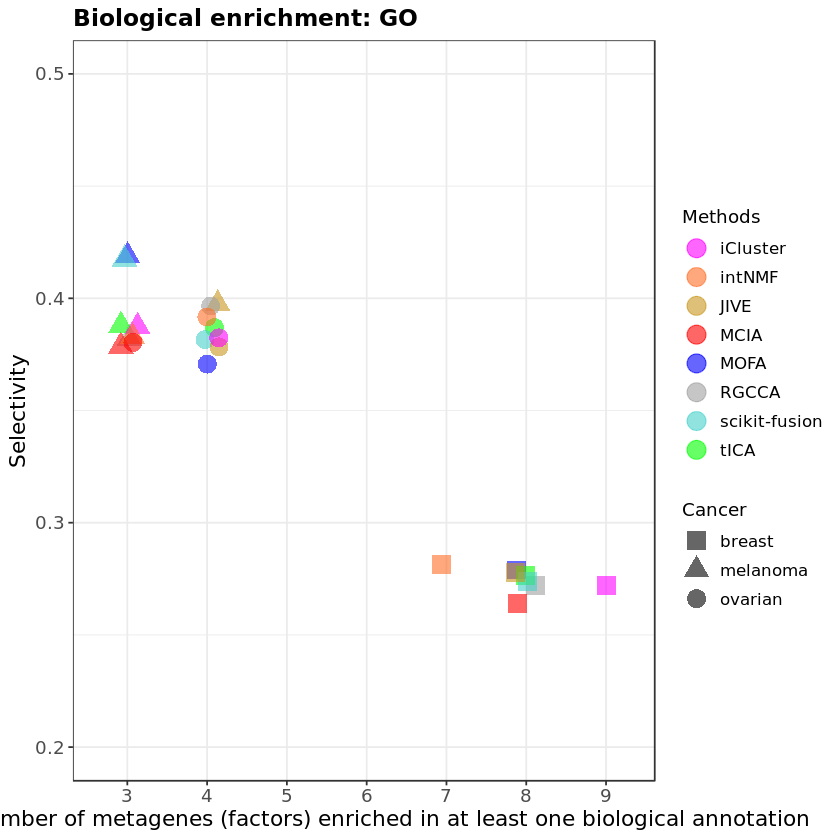

In [9]:
# BioEnr_go_fig1
go_dta <- go_pathway[go_pathway$cancer=="breast"| go_pathway$cancer=="ovarian"|go_pathway$cancer=="melanoma",];
#tiff("BioEnr_go_fig1.tiff", units="in", width=8.95, height=6.05, res=300)
g <- ggplot(go_dta, 
          aes(x=nonZeroFacs,y=selectivity))+ geom_point(aes(colour = methods, shape = cancer),size=5,
                                                        alpha=.6,position=position_jitter(h=0, w=0.15))+ theme_bw() + scale_shape_manual(values=c(15,17,16))+ 
  scale_color_manual(values=c('#FF00FF','#FF6E28', '#C8961E', '#FF0000','#0000FF','#A0A0A0','#48D1CC','#00FF00'))+
  ylim(floor(min((go_dta[,"selectivity"]*10)-.4))/10,ceiling(max((go_dta[,"selectivity"]*10)+.2))/10)+
  labs(title="Biological enrichment: GO ", x=" The number of metagenes (factors) enriched in at least one biological annotation")+
  theme(plot.title = element_text(size=14,face="bold"),axis.text = element_text(size=11),axis.title = element_text(size=13),legend.text=element_text(size=10))+
  ylab("Selectivity")+labs(colour = "Methods",shape="Cancer")+
  guides(color = guide_legend(order = 1),shape = guide_legend(order = 2),size = guide_legend(order = 3));

min_nonZero = min(go_pathway[go_pathway$cancer=="breast"| go_pathway$cancer=="ovarian"|go_pathway$cancer=="melanoma","nonZeroFacs"]) 
max_nonZero = max(go_pathway[go_pathway$cancer=="breast"| go_pathway$cancer=="ovarian"|go_pathway$cancer=="melanoma","nonZeroFacs"]) 
g <- g + scale_x_discrete()
g <- g + scale_x_discrete(limits=min_nonZero :max_nonZero)
g <- g + scale_x_discrete(limits=min_nonZero :max_nonZero, labels = c(min_nonZero :max_nonZero));
g
#dev.off()

ggsave("BioEnr_go_fig1.pdf",dpi=300)
ggsave("BioEnr_go_fig1.png",dpi=300)  


#### Figure 2

Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.
Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image


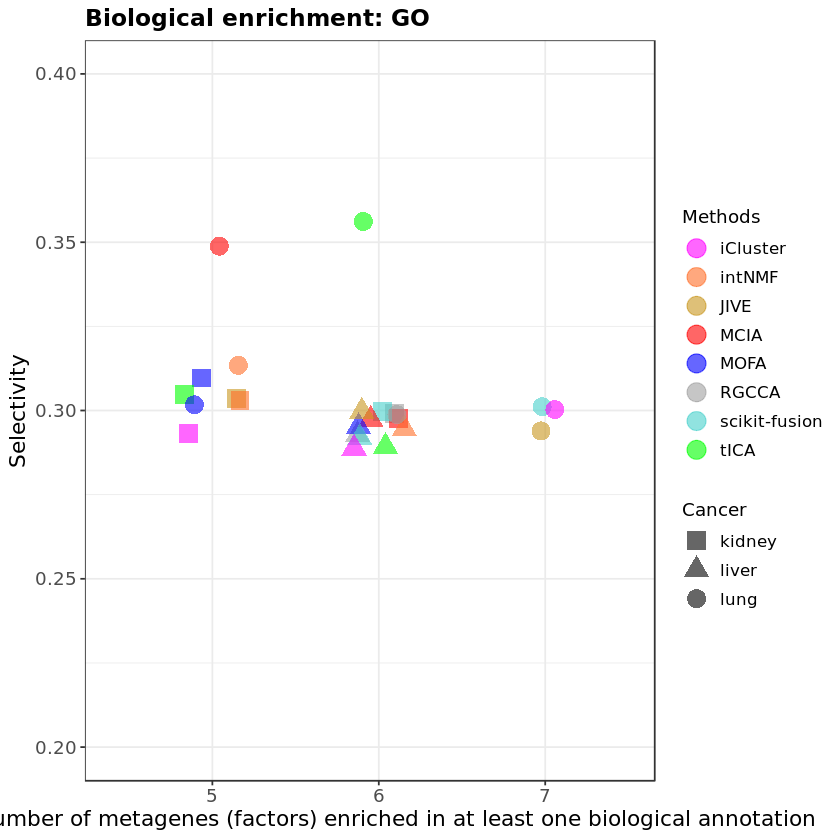

In [10]:
#BioEnr_go_fig2
go_dta <- go_pathway[go_pathway$cancer=="lung"| go_pathway$cancer=="kidney"|go_pathway$cancer=="liver",];
#tiff("BioEnr_go_fig2.tiff", units="in", width=8.95, height=6.05, res=300)
g <- ggplot(go_dta,
          aes(x=nonZeroFacs,y=selectivity))+ geom_point(aes(colour = methods, shape = cancer),size=5,
                                                        alpha=.6,position=position_jitter(h=0, w=0.17))+ theme_bw() + scale_shape_manual(values=c(15,17,16))+ 
  scale_color_manual(values=c('#FF00FF','#FF6E28', '#C8961E', '#FF0000','#0000FF','#A0A0A0','#48D1CC','#00FF00'))+
  ylim(floor(min((go_dta[,"selectivity"]*10)-.2))/10,ceiling(max((go_dta[,"selectivity"]*10)+0))/10)+
  labs(title="Biological enrichment: GO ", x=" The number of metagenes (factors) enriched in at least one biological annotation")+
  theme(plot.title = element_text(size=14,face="bold"),axis.text = element_text(size=11),axis.title = element_text(size=13),legend.text=element_text(size=10))+
  ylab("Selectivity")+labs(colour = "Methods",shape="Cancer")+
  guides(color = guide_legend(order = 1),shape = guide_legend(order = 2),size = guide_legend(order = 3));

min_nonZero = min(go_pathway[go_pathway$cancer=="lung"| go_pathway$cancer=="kidney"|go_pathway$cancer=="liver","nonZeroFacs"]); 
max_nonZero = max(go_pathway[go_pathway$cancer=="lung"| go_pathway$cancer=="kidney"|go_pathway$cancer=="liver","nonZeroFacs"]) ;
g <- g + scale_x_discrete()
g <- g + scale_x_discrete(limits=min_nonZero :max_nonZero)
g <- g + scale_x_discrete(limits=min_nonZero :max_nonZero, labels = c(min_nonZero :max_nonZero));                   
g
#dev.off()

ggsave("BioEnr_go_fig2.pdf",dpi=300)
ggsave("BioEnr_go_fig2.png",dpi=300)  


#### Figure 3

Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.
Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image


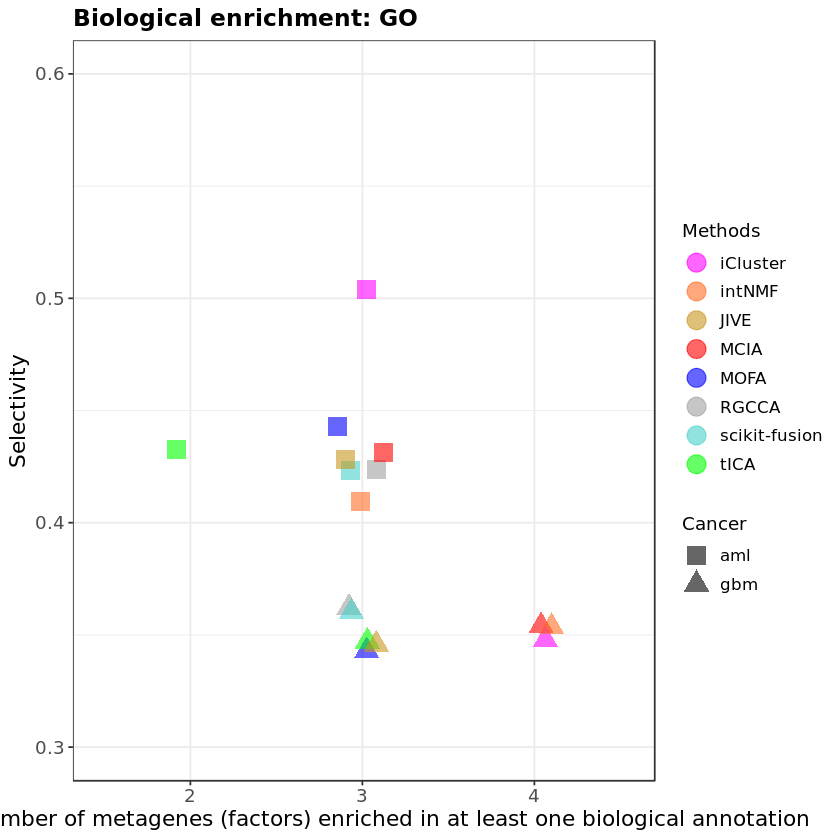

In [11]:
#BioEnr_go_fig3
go_dta <- go_pathway[go_pathway$cancer=="aml"| go_pathway$cancer=="gbm",]
#tiff("BioEnr_go_fig3.tiff", units="in", width=8.95, height=6.05, res=300)
g <- ggplot(go_dta,
          aes(x=nonZeroFacs,y=selectivity))+ geom_point(aes(colour = methods, shape = cancer),size=5,
                                                        alpha=.6,position=position_jitter(h=0, w=0.15))+ theme_bw() + scale_shape_manual(values=c(15,17,3))+ 
  scale_color_manual(values=c('#FF00FF','#FF6E28', '#C8961E', '#FF0000','#0000FF','#A0A0A0','#48D1CC','#00FF00'))+
  ylim(floor(min((go_dta[,"selectivity"]*10)-.4))/10,ceiling(max((go_dta[,"selectivity"]*10)+.2))/10)+
  labs(title="Biological enrichment: GO ", x=" The number of metagenes (factors) enriched in at least one biological annotation")+
  theme(plot.title = element_text(size=14,face="bold"),axis.text = element_text(size=11),axis.title = element_text(size=13),legend.text=element_text(size=10))+
  ylab("Selectivity")+labs(colour = "Methods",shape="Cancer")+
  guides(color = guide_legend(order = 1),shape = guide_legend(order = 2),size = guide_legend(order = 3));

min_nonZero = min(go_pathway[go_pathway$cancer=="aml"| go_pathway$cancer=="gbm","nonZeroFacs"]) 
max_nonZero = max(go_pathway[go_pathway$cancer=="aml"| go_pathway$cancer=="gbm","nonZeroFacs"]) 
g <- g + scale_x_discrete()
g <- g + scale_x_discrete(limits=min_nonZero :max_nonZero)
g <- g + scale_x_discrete(limits=min_nonZero :max_nonZero, labels = c(min_nonZero :max_nonZero));                                           
g
#dev.off()

ggsave("BioEnr_go_fig3.pdf",dpi=300)
ggsave("BioEnr_go_fig3.png",dpi=300)  

#### Figure 4

Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.
Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image


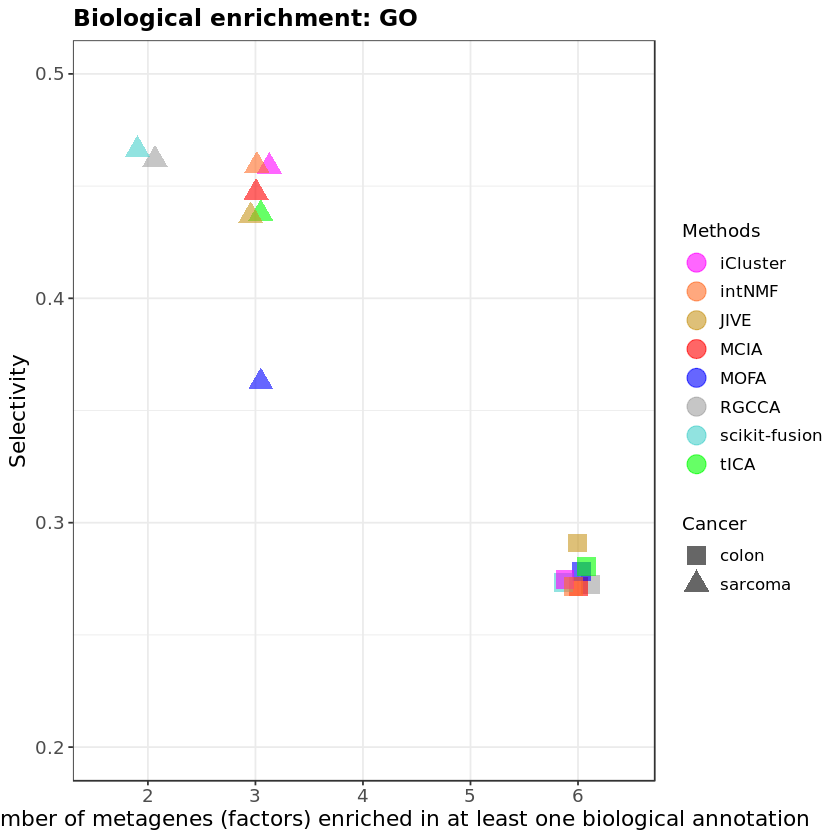

In [12]:
#BioEnr_go_fig4

go_dta <- go_pathway[go_pathway$cancer=="colon"| go_pathway$cancer=="sarcoma",]
#tiff("BioEnr_go_fig4.tiff", units="in", width=8.95, height=6.05, res=300)
g <- ggplot(go_dta,
          aes(x=nonZeroFacs,y=selectivity))+ geom_point(aes(colour = methods, shape = cancer),size=5,
                                                        alpha=.6,position=position_jitter(h=0, w=0.15))+ theme_bw() + scale_shape_manual(values=c(15,17,3))+ 
  scale_color_manual(values=c('#FF00FF','#FF6E28', '#C8961E', '#FF0000','#0000FF','#A0A0A0','#48D1CC','#00FF00'))+
  ylim(floor(min((go_dta[,"selectivity"]*10)-.4))/10,ceiling(max((go_dta[,"selectivity"]*10)+.2))/10)+
  labs(title="Biological enrichment: GO ", x=" The number of metagenes (factors) enriched in at least one biological annotation")+
  theme(plot.title = element_text(size=14,face="bold"),axis.text = element_text(size=11),axis.title = element_text(size=13),legend.text=element_text(size=10))+
  ylab("Selectivity")+labs(colour = "Methods",shape="Cancer")+
  guides(color = guide_legend(order = 1),shape = guide_legend(order = 2),size = guide_legend(order = 3));

min_nonZero = min(go_pathway[go_pathway$cancer=="colon"| go_pathway$cancer=="sarcoma","nonZeroFacs"]) 
max_nonZero = max(go_pathway[go_pathway$cancer=="colon"| go_pathway$cancer=="sarcoma","nonZeroFacs"]) 
g <- g + scale_x_discrete()
g <- g + scale_x_discrete(limits=min_nonZero :max_nonZero)
g <- g + scale_x_discrete(limits=min_nonZero :max_nonZero, labels = c(min_nonZero :max_nonZero));    
g
#dev.off()

ggsave("BioEnr_go_fig4.pdf",dpi=300)
ggsave("BioEnr_go_fig4.png",dpi=300)  


### Biological Enrichment: HALLMARKS

In [13]:
go_HALLMARKS <- readRDS("../drive_docs/HALLMARKS_pathways.rds")

#### Figure 1

Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.
Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image


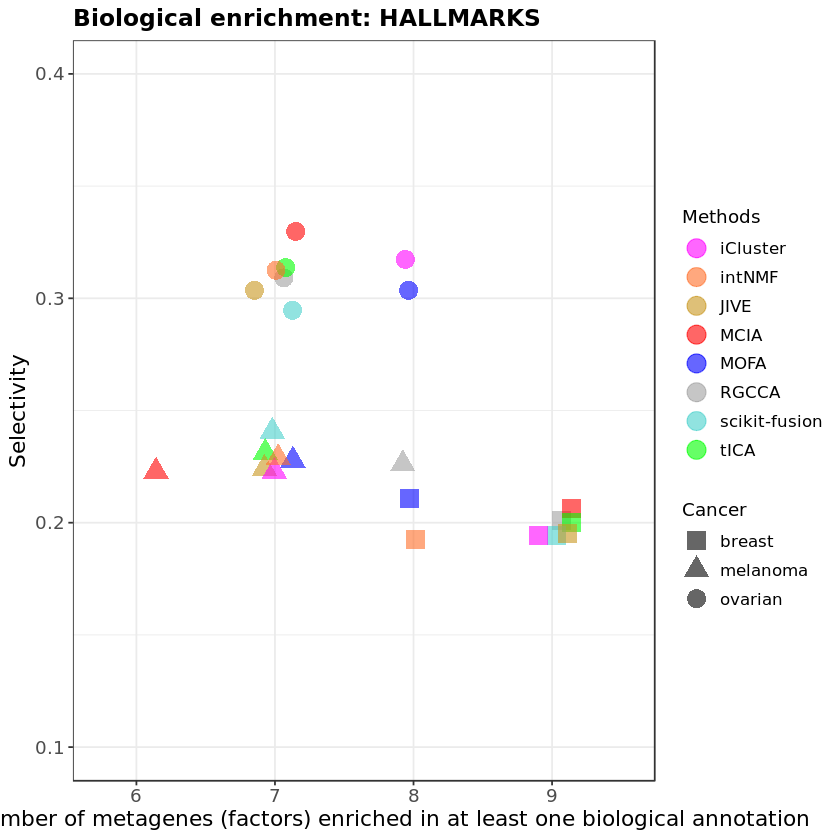

In [14]:
#BioEnr_HALLMARKS_fig1
hallmarks_dta <- go_HALLMARKS[go_HALLMARKS$cancer=="breast"| go_HALLMARKS$cancer=="ovarian"|go_HALLMARKS$cancer=="melanoma",]
#tiff("BioEnr_HALLMARKS_fig1.tiff", units="in", width=8.95, height=6.05, res=300)
gHal <- ggplot(hallmarks_dta,
             aes(x=nonZeroFacs,y=selectivity))+ geom_point(aes(colour = methods, shape = cancer),size=5,
                                                           alpha=.6,position=position_jitter(h=0, w=0.15))+ theme_bw() + scale_shape_manual(values=c(15,17,16))+ 
  scale_color_manual(values=c('#FF00FF','#FF6E28', '#C8961E', '#FF0000','#0000FF','#A0A0A0','#48D1CC','#00FF00'))+
  ylim(floor(min((hallmarks_dta[,"selectivity"]*10)-.4))/10,ceiling(max((hallmarks_dta[,"selectivity"]*10)+.2))/10)+
  labs(title="Biological enrichment: HALLMARKS", x=" The number of metagenes (factors) enriched in at least one biological annotation")+
  theme(plot.title = element_text(size=14,face="bold"),axis.text = element_text(size=11),axis.title = element_text(size=13),legend.text=element_text(size=10))+
  ylab("Selectivity")+labs(colour = "Methods",shape="Cancer")+
  guides(color = guide_legend(order = 1),shape = guide_legend(order = 2),size = guide_legend(order = 3));

min_nonZero = min(go_HALLMARKS[go_HALLMARKS$cancer=="breast"| go_HALLMARKS$cancer=="ovarian"|go_HALLMARKS$cancer=="melanoma","nonZeroFacs"]) 
max_nonZero = max(go_HALLMARKS[go_HALLMARKS$cancer=="breast"| go_HALLMARKS$cancer=="ovarian"|go_HALLMARKS$cancer=="melanoma","nonZeroFacs"]) 
gHal <- gHal + scale_x_discrete()
gHal <- gHal + scale_x_discrete(limits=min_nonZero :max_nonZero)
gHal <- gHal + scale_x_discrete(limits=min_nonZero :max_nonZero, labels = c(min_nonZero :max_nonZero)); 
gHal
#dev.off()

ggsave("BioEnr_HALLMARKS_fig1.pdf",dpi=300)
ggsave("BioEnr_HALLMARKS_fig1.png",dpi=300)  

#### Figure 2

Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.
Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image


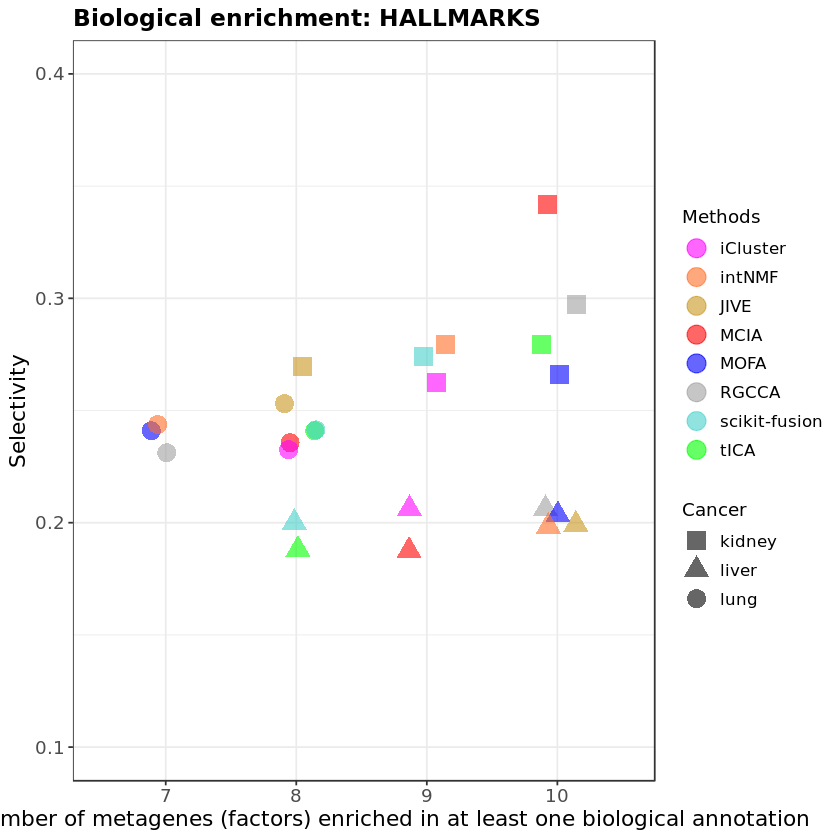

In [15]:
#BioEnr_HALLMARKS_fig2
hallmarks_dta= go_HALLMARKS[go_HALLMARKS$cancer=="lung"| go_HALLMARKS$cancer=="kidney"|go_HALLMARKS$cancer=="liver",]

#tiff("BioEnr_HALLMARKS_fig2.tiff", units="in", width=8.95, height=6.05, res=300)
gHal <- ggplot(hallmarks_dta,
             aes(x=nonZeroFacs,y=selectivity))+ geom_point(aes(colour = methods, shape = cancer),size=5,
                                                           alpha=.6,position=position_jitter(h=0, w=0.15))+ theme_bw() + scale_shape_manual(values=c(15,17,16))+ 
  scale_color_manual(values=c('#FF00FF','#FF6E28', '#C8961E', '#FF0000','#0000FF','#A0A0A0','#48D1CC','#00FF00'))+
  ylim(floor(min((hallmarks_dta[,"selectivity"]*10)-.4))/10,ceiling(max((hallmarks_dta[,"selectivity"]*10)+.2))/10)+
  labs(title="Biological enrichment: HALLMARKS", x=" The number of metagenes (factors) enriched in at least one biological annotation")+
  theme(plot.title = element_text(size=14,face="bold"),axis.text = element_text(size=11),axis.title = element_text(size=13),legend.text=element_text(size=10))+
  ylab("Selectivity")+labs(colour = "Methods",shape="Cancer")+
  guides(color = guide_legend(order = 1),shape = guide_legend(order = 2),size = guide_legend(order = 3));

min_nonZero = min(go_HALLMARKS[go_HALLMARKS$cancer=="lung"| go_HALLMARKS$cancer=="kidney"|go_HALLMARKS$cancer=="liver","nonZeroFacs"]) 
max_nonZero = max(go_HALLMARKS[go_HALLMARKS$cancer=="lung"| go_HALLMARKS$cancer=="kidney"|go_HALLMARKS$cancer=="liver","nonZeroFacs"]) 
gHal <- gHal + scale_x_discrete()
gHal <- gHal + scale_x_discrete(limits=min_nonZero :max_nonZero)
gHal <- gHal + scale_x_discrete(limits=min_nonZero :max_nonZero, labels = c(min_nonZero :max_nonZero));                   
gHal
#dev.off()

ggsave("BioEnr_HALLMARKS_fig2.pdf", dpi=300)
ggsave("BioEnr_HALLMARKS_fig2.png", dpi=300)

#### Figure 3

Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.
Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image


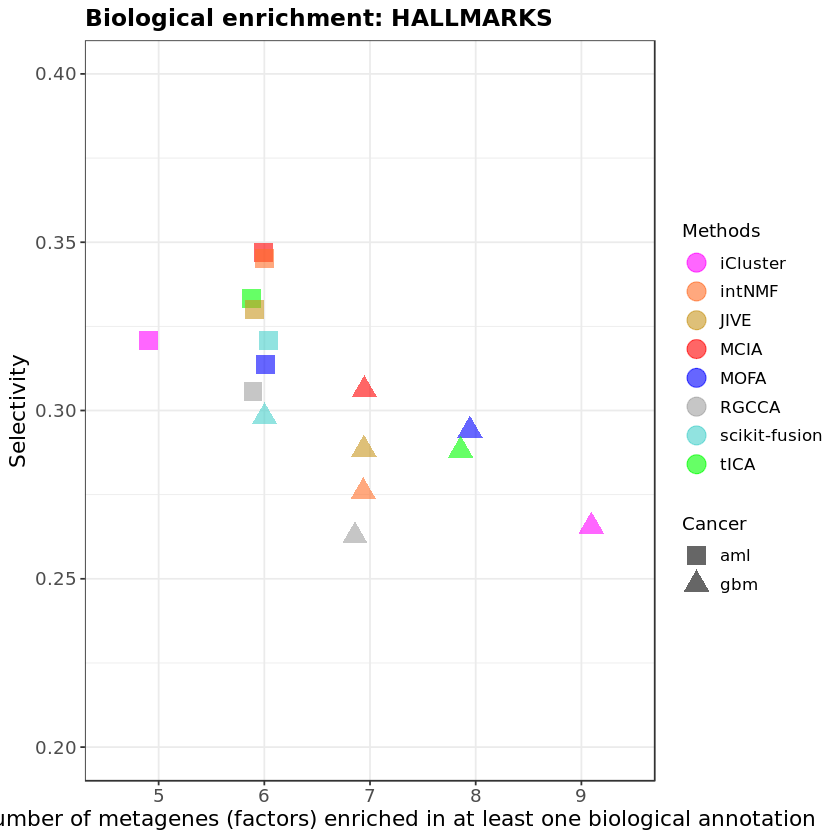

In [16]:
#BioEnr_HALLMARKS_fig3                       
hallmarks_dta <- go_HALLMARKS[go_HALLMARKS$cancer=="aml"| go_HALLMARKS$cancer=="gbm",];
#tiff("BioEnr_HALLMARKS_fig3.tiff", units="in", width=8.95, height=6.05, res=300)
gHal <- ggplot(hallmarks_dta,
             aes(x=nonZeroFacs,y=selectivity))+ geom_point(aes(colour = methods, shape = cancer),size=5,
                                                           alpha=.6,position=position_jitter(h=0, w=0.15))+ theme_bw() + scale_shape_manual(values=c(15,17,3))+ 
  scale_color_manual(values=c('#FF00FF','#FF6E28', '#C8961E', '#FF0000','#0000FF','#A0A0A0','#48D1CC','#00FF00'))+
  ylim(floor(min((hallmarks_dta[,"selectivity"]*10)-.4))/10,ceiling(max((hallmarks_dta[,"selectivity"]*10)+.2))/10)+
  labs(title="Biological enrichment: HALLMARKS", x=" The number of metagenes (factors) enriched in at least one biological annotation")+
  theme(plot.title = element_text(size=14,face="bold"),axis.text = element_text(size=11),axis.title = element_text(size=13),legend.text=element_text(size=10))+
  ylab("Selectivity")+labs(colour = "Methods",shape="Cancer")+
  guides(color = guide_legend(order = 1),shape = guide_legend(order = 2),size = guide_legend(order = 3));

min_nonZero = min(go_HALLMARKS[go_HALLMARKS$cancer=="aml"| go_HALLMARKS$cancer=="gbm","nonZeroFacs"]) 
max_nonZero = max(go_HALLMARKS[go_HALLMARKS$cancer=="aml"| go_HALLMARKS$cancer=="gbm","nonZeroFacs"]) 
gHal <- gHal + scale_x_discrete()
gHal <- gHal + scale_x_discrete(limits=min_nonZero :max_nonZero)
gHal <- gHal + scale_x_discrete(limits=min_nonZero :max_nonZero, labels = c(min_nonZero :max_nonZero)); 
gHal
#dev.off()

ggsave("BioEnr_HALLMARKS_fig3.pdf",dpi=300)
ggsave("BioEnr_HALLMARKS_fig3.png",dpi=300)  

#### Figure 4

Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.
Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image


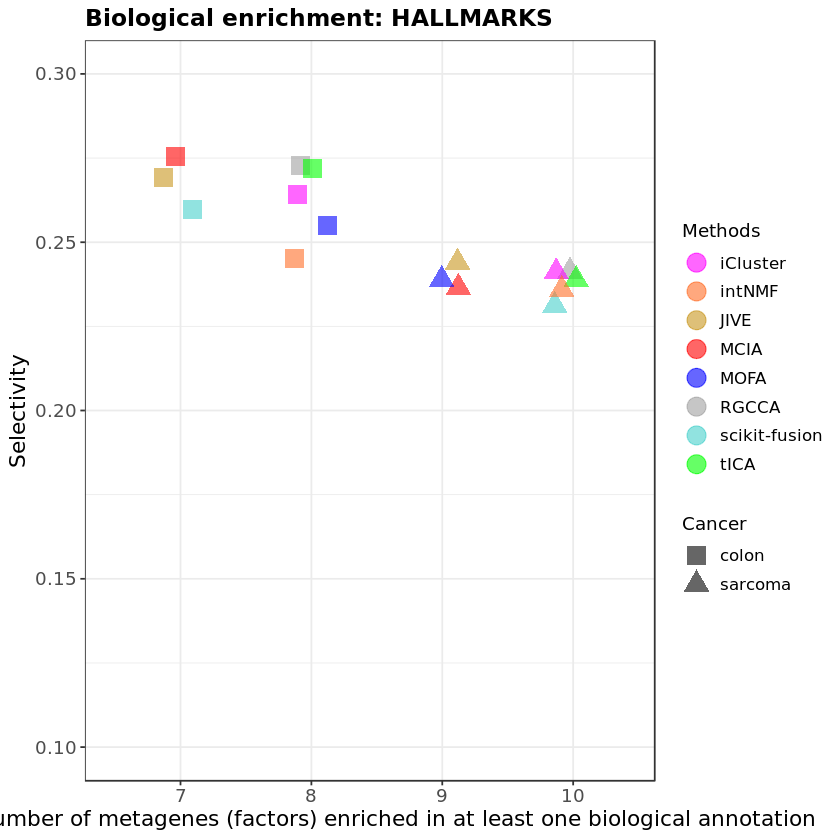

In [17]:
#BioEnr_HALLMARKS_fig4                     
hallmarks_dta <- go_HALLMARKS[go_HALLMARKS$cancer=="colon"| go_HALLMARKS$cancer=="sarcoma",];
#tiff("BioEnr_HALLMARKS_fig4.tiff", units="in", width=8.95, height=6.05, res=300)
gHal <- ggplot(hallmarks_dta,
             aes(x=nonZeroFacs,y=selectivity))+ geom_point(aes(colour = methods, shape = cancer),size=5,
                                                           alpha=.6,position=position_jitter(h=0, w=0.15))+ theme_bw() + scale_shape_manual(values=c(15,17,3))+ 
  scale_color_manual(values=c('#FF00FF','#FF6E28', '#C8961E', '#FF0000','#0000FF','#A0A0A0','#48D1CC','#00FF00'))+
  ylim(floor(min((hallmarks_dta[,"selectivity"]*10)-.4))/10,ceiling(max((hallmarks_dta[,"selectivity"]*10)+.2))/10)+
  labs(title="Biological enrichment: HALLMARKS", x=" The number of metagenes (factors) enriched in at least one biological annotation")+
  theme(plot.title = element_text(size=14,face="bold"),axis.text = element_text(size=11),axis.title = element_text(size=13),legend.text=element_text(size=10))+
  ylab("Selectivity")+labs(colour = "Methods",shape="Cancer")+
  guides(color = guide_legend(order = 1),shape = guide_legend(order = 2),size = guide_legend(order = 3));

min_nonZero = min(go_HALLMARKS[go_HALLMARKS$cancer=="colon"| go_HALLMARKS$cancer=="sarcoma","nonZeroFacs"]) 
max_nonZero = max(go_HALLMARKS[go_HALLMARKS$cancer=="colon"| go_HALLMARKS$cancer=="sarcoma","nonZeroFacs"]) 
gHal <- gHal + scale_x_discrete()
gHal <- gHal + scale_x_discrete(limits=min_nonZero :max_nonZero)
gHal <- gHal + scale_x_discrete(limits=min_nonZero :max_nonZero, labels = c(min_nonZero :max_nonZero));                                                                                                                                                          
gHal
#dev.off()

ggsave("BioEnr_HALLMARKS_fig4.pdf",dpi=300)
ggsave("BioEnr_HALLMARKS_fig4.png",dpi=300)  

### Biological enrichment: REACTOME

In [18]:
go_REACTOME <- readRDS("../drive_docs/REACTOME_pathways.rds")

#### Figure 1

Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.
Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image


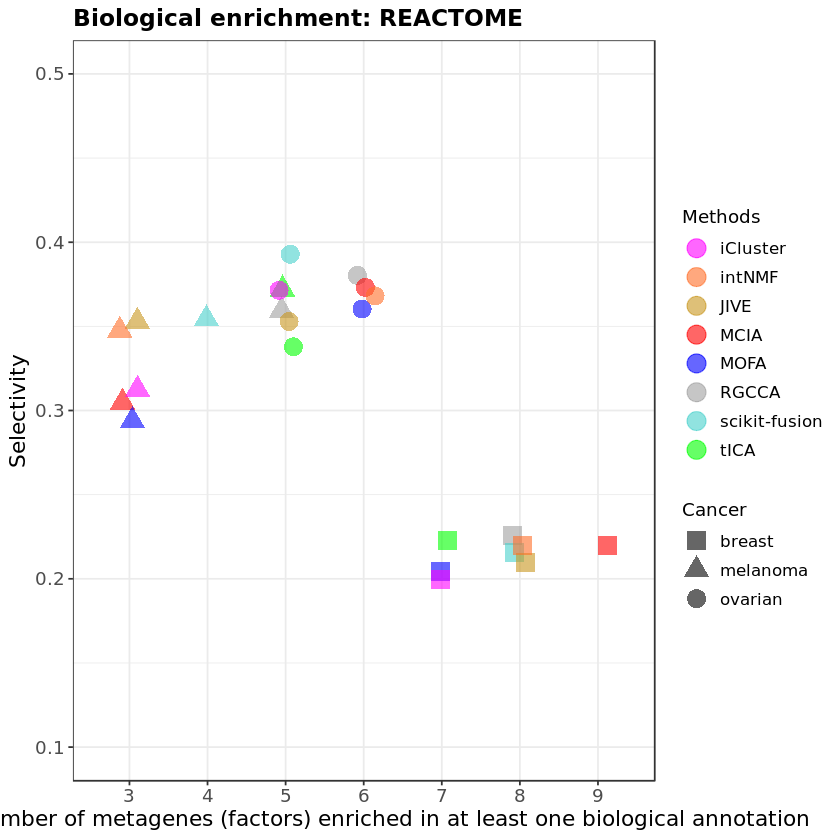

In [19]:
#BioEnr_REACTOME_fig1
REACTOME_dta <- go_REACTOME[go_REACTOME$cancer=="breast"| go_REACTOME$cancer=="ovarian"|go_REACTOME$cancer=="melanoma",];
#tiff("BioEnr_REACTOME_fig1.tiff", units="in", width=8.95, height=6.05, res=300)
gREC <- ggplot(REACTOME_dta,
             aes(x=nonZeroFacs,y=selectivity))+ geom_point(aes(colour = methods, shape = cancer),size=5,
                                                           alpha=.6,position=position_jitter(h=0, w=0.15))+ theme_bw() + scale_shape_manual(values=c(15,17,16))+ 
  scale_color_manual(values=c('#FF00FF','#FF6E28', '#C8961E', '#FF0000','#0000FF','#A0A0A0','#48D1CC','#00FF00'))+
  ylim(floor(min((REACTOME_dta[,"selectivity"]*10)-.4))/10,ceiling(max((REACTOME_dta[,"selectivity"]*10)+.2))/10)+
  labs(title="Biological enrichment: REACTOME", x=" The number of metagenes (factors) enriched in at least one biological annotation")+
  theme(plot.title = element_text(size=14,face="bold"),axis.text = element_text(size=11),axis.title = element_text(size=13),legend.text=element_text(size=10))+
  ylab("Selectivity")+labs(colour = "Methods",shape="Cancer")+
  guides(color = guide_legend(order = 1),shape = guide_legend(order = 2),size = guide_legend(order = 3));         

min_nonZero = min(go_REACTOME[go_REACTOME$cancer=="breast"| go_REACTOME$cancer=="ovarian"|go_REACTOME$cancer=="melanoma","nonZeroFacs"]) 
max_nonZero = max(go_REACTOME[go_REACTOME$cancer=="breast"| go_REACTOME$cancer=="ovarian"|go_REACTOME$cancer=="melanoma","nonZeroFacs"]) 
gREC <- gREC + scale_x_discrete()
gREC <- gREC + scale_x_discrete(limits=min_nonZero :max_nonZero)
gREC <- gREC + scale_x_discrete(limits=min_nonZero :max_nonZero, labels = c(min_nonZero :max_nonZero));
gREC
#dev.off()

ggsave("BioEnr_REACTOME_fig1.pdf",dpi=300)
ggsave("BioEnr_REACTOME_fig1.png",dpi=300)  


#### Figure 2

Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.
Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image


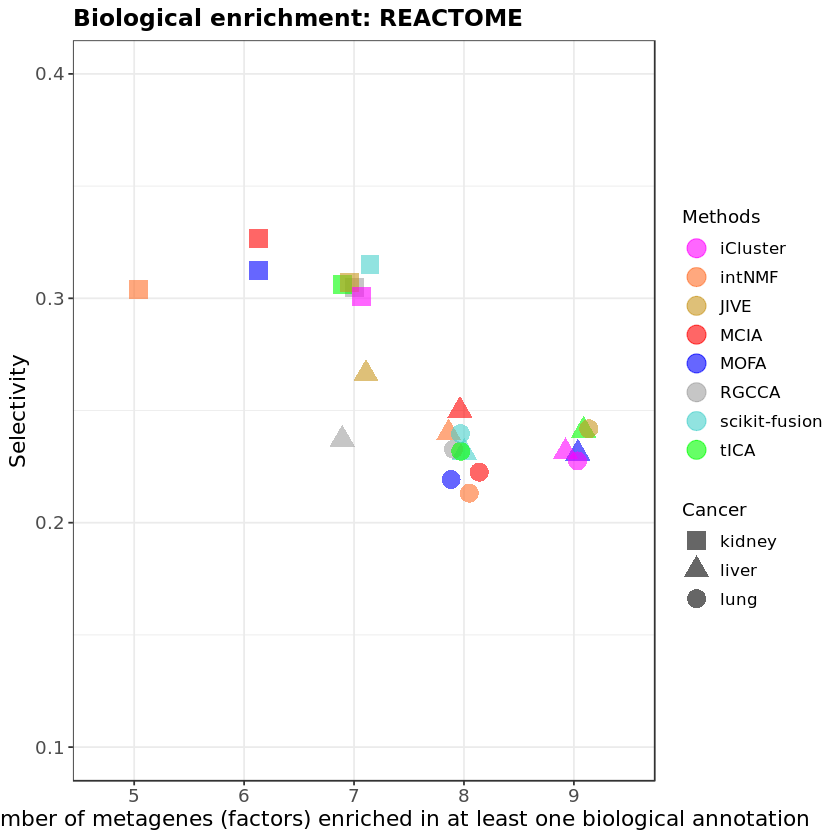

In [20]:
#BioEnr_REACTOME_fig2
REACTOME_dta <- go_REACTOME[go_REACTOME$cancer=="lung"| go_REACTOME$cancer=="kidney"|go_REACTOME$cancer=="liver",];
#tiff("BioEnr_REACTOME_fig2.tiff", units="in", width=8.95, height=6.05, res=300)
gREC <- ggplot(REACTOME_dta,
             aes(x=nonZeroFacs,y=selectivity))+ geom_point(aes(colour = methods, shape = cancer),size=5,
                                                           alpha=.6,position=position_jitter(h=0, w=0.15))+ theme_bw() + scale_shape_manual(values=c(15,17,16))+ 
  scale_color_manual(values=c('#FF00FF','#FF6E28', '#C8961E', '#FF0000','#0000FF','#A0A0A0','#48D1CC','#00FF00'))+
  ylim(floor(min((REACTOME_dta[,"selectivity"]*10)-.4))/10,ceiling(max((REACTOME_dta[,"selectivity"]*10)+.2))/10)+
  labs(title="Biological enrichment: REACTOME", x=" The number of metagenes (factors) enriched in at least one biological annotation")+
  theme(plot.title = element_text(size=14,face="bold"),axis.text = element_text(size=11),axis.title = element_text(size=13),legend.text=element_text(size=10))+
  ylab("Selectivity")+labs(colour = "Methods",shape="Cancer")+
  guides(color = guide_legend(order = 1),shape = guide_legend(order = 2),size = guide_legend(order = 3));        

min_nonZero = min(go_REACTOME[go_REACTOME$cancer=="lung"| go_REACTOME$cancer=="kidney"|go_REACTOME$cancer=="liver","nonZeroFacs"]) 
max_nonZero = max(go_REACTOME[go_REACTOME$cancer=="lung"| go_REACTOME$cancer=="kidney"|go_REACTOME$cancer=="liver","nonZeroFacs"]) 
gREC <- gREC + scale_x_discrete()
gREC <- gREC + scale_x_discrete(limits=min_nonZero :max_nonZero)
gREC <- gREC+ scale_x_discrete(limits=min_nonZero :max_nonZero, labels = c(min_nonZero :max_nonZero));                   
gREC
#dev.off()

ggsave("BioEnr_REACTOME_fig2.pdf",dpi=300)
ggsave("BioEnr_REACTOME_fig2.png",dpi=300)  

#### Figure 3

Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.
Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image


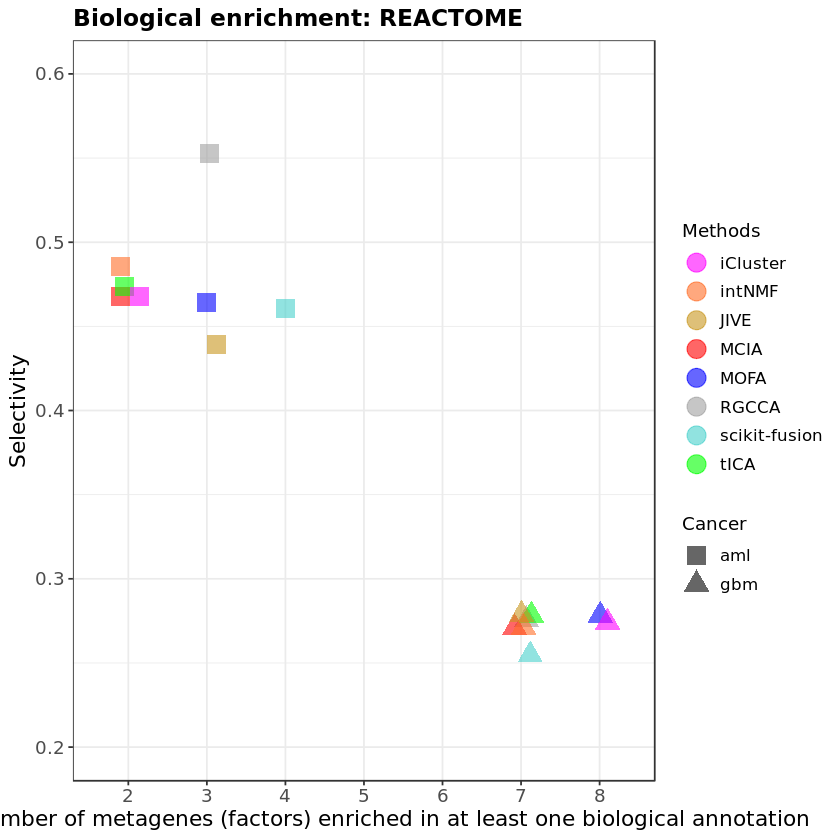

In [21]:
#BioEnr_REACTOME_fig3                                            
REACTOME_dta= go_REACTOME[go_REACTOME$cancer=="aml"| go_REACTOME$cancer=="gbm",];
#tiff("BioEnr_REACTOME_fig3.tiff", units="in", width=8.95, height=6.05, res=300)
gREC <- ggplot(REACTOME_dta,
             aes(x=nonZeroFacs,y=selectivity))+ geom_point(aes(colour = methods, shape = cancer),size=5,
                                                           alpha=.6,position=position_jitter(h=0, w=0.15))+ theme_bw() + scale_shape_manual(values=c(15,17,3))+ 
  scale_color_manual(values=c('#FF00FF','#FF6E28', '#C8961E', '#FF0000','#0000FF','#A0A0A0','#48D1CC','#00FF00'))+
  ylim(floor(min((REACTOME_dta[,"selectivity"]*10)-.4))/10,ceiling(max((REACTOME_dta[,"selectivity"]*10)+.2))/10)+
  labs(title="Biological enrichment: REACTOME", x=" The number of metagenes (factors) enriched in at least one biological annotation")+
  theme(plot.title = element_text(size=14,face="bold"),axis.text = element_text(size=11),axis.title = element_text(size=13),legend.text=element_text(size=10))+
  ylab("Selectivity")+labs(colour = "Methods",shape="Cancer")+
  guides(color = guide_legend(order = 1),shape = guide_legend(order = 2),size = guide_legend(order = 3));

min_nonZero = min(go_REACTOME[go_REACTOME$cancer=="aml"| go_REACTOME$cancer=="gbm","nonZeroFacs"]) 
max_nonZero = max(go_REACTOME[go_REACTOME$cancer=="aml"| go_REACTOME$cancer=="gbm","nonZeroFacs"]) 
gREC <- gREC + scale_x_discrete()
gREC <- gREC + scale_x_discrete(limits=min_nonZero :max_nonZero)
gREC <- gREC + scale_x_discrete(limits=min_nonZero :max_nonZero, labels = c(min_nonZero :max_nonZero));
gREC
#dev.off()

ggsave("BioEnr_REACTOME_fig3.pdf",dpi=300)
ggsave("BioEnr_REACTOME_fig3.png",dpi=300)  

#### Figure 4

Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.
Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image


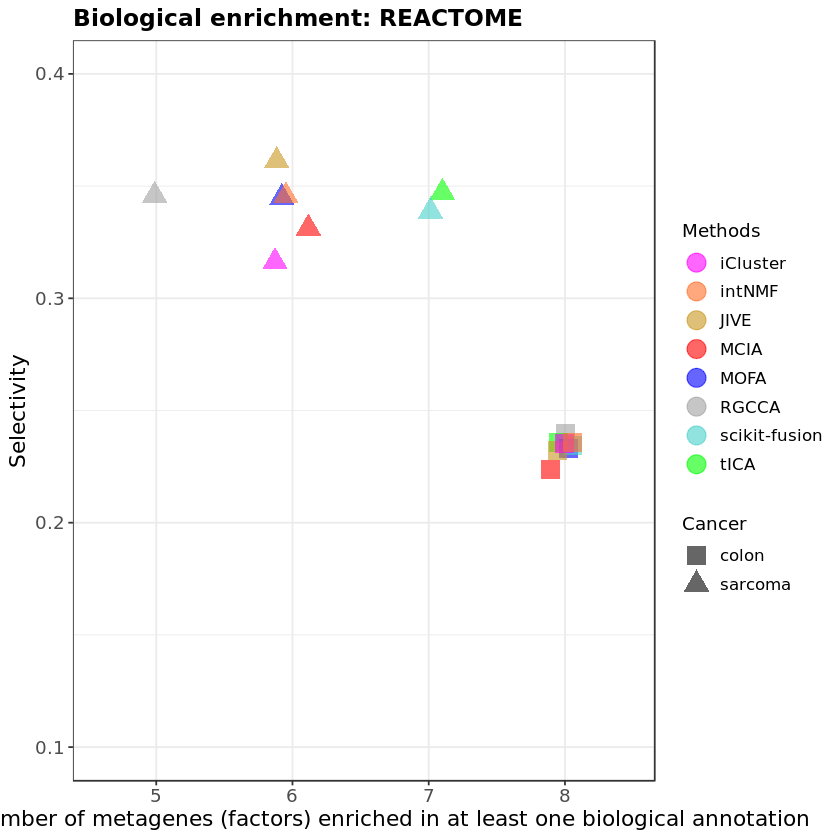

In [22]:
#BioEnr_REACTOME_fig4
REACTOME_dta <- go_REACTOME[go_REACTOME$cancer=="colon"| go_REACTOME$cancer=="sarcoma",];
#tiff("BioEnr_REACTOME_fig4.tiff", units="in", width=8.95, height=6.05, res=300)
gREC <- ggplot(REACTOME_dta,
             aes(x=nonZeroFacs,y=selectivity))+ geom_point(aes(colour = methods, shape = cancer),size=5,
                                                           alpha=.6,position=position_jitter(h=0, w=0.15))+ theme_bw() + scale_shape_manual(values=c(15,17,3))+ 
  scale_color_manual(values=c('#FF00FF','#FF6E28', '#C8961E', '#FF0000','#0000FF','#A0A0A0','#48D1CC','#00FF00'))+
  ylim(floor(min((REACTOME_dta[,"selectivity"]*10)-.4))/10,ceiling(max((REACTOME_dta[,"selectivity"]*10)+.2))/10)+
  labs(title="Biological enrichment: REACTOME", x=" The number of metagenes (factors) enriched in at least one biological annotation")+
  theme(plot.title = element_text(size=14,face="bold"),axis.text = element_text(size=11),axis.title = element_text(size=13),legend.text=element_text(size=10))+
  ylab("Selectivity")+labs(colour = "Methods",shape="Cancer")+
  guides(color = guide_legend(order = 1),shape = guide_legend(order = 2),size = guide_legend(order = 3));

min_nonZero = min(go_REACTOME[go_REACTOME$cancer=="colon"| go_REACTOME$cancer=="sarcoma","nonZeroFacs"]) 
max_nonZero = max(go_REACTOME[go_REACTOME$cancer=="colon"| go_REACTOME$cancer=="sarcoma","nonZeroFacs"]) 
gREC <- gREC + scale_x_discrete()
gREC <- gREC + scale_x_discrete(limits=min_nonZero :max_nonZero)
gREC <- gREC + scale_x_discrete(limits=min_nonZero :max_nonZero, labels = c(min_nonZero :max_nonZero));
gREC
#dev.off()

ggsave("BioEnr_REACTOME_fig4.pdf",dpi=300)
ggsave("BioEnr_REACTOME_fig4.png",dpi=300)  

### Clinical annotation

In [23]:
cliAnn <- readRDS("../drive_docs/clinical_Ann.rds")

#### Figure 1

Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.
Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image


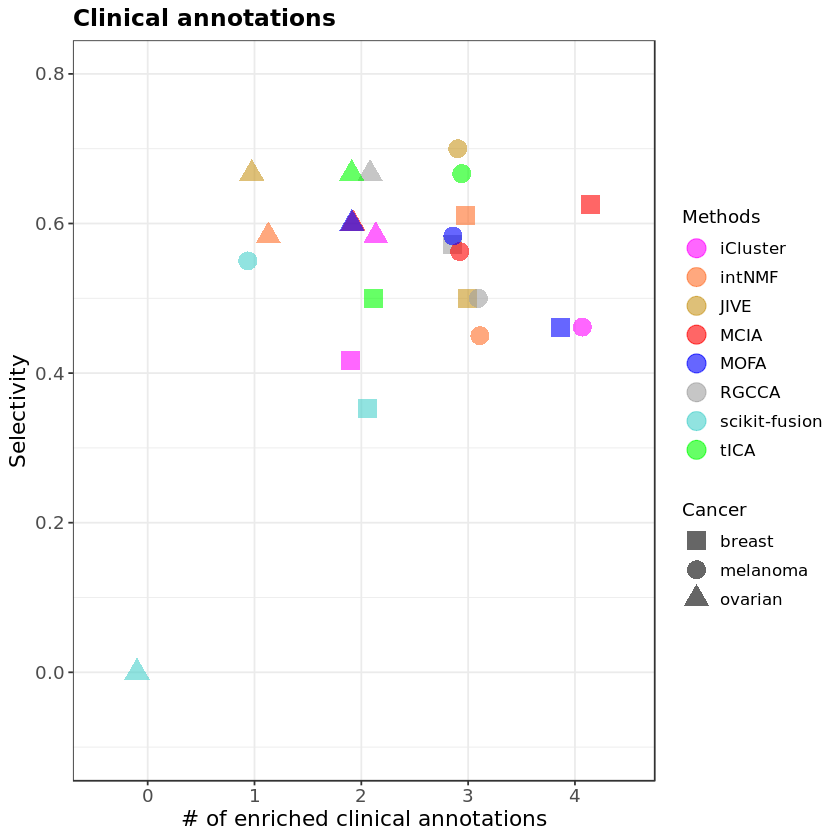

In [24]:
#cliAnn_fig1
cliAnn_dta <- cliAnn[cliAnn$cancer=="breast"| cliAnn$cancer=="ovarian"|cliAnn$cancer=="melanoma",];
#tiff("cliAnn_fig1.tiff", units="in", width=8.95, height=6.05, res=300)
gCli <- ggplot(cliAnn_dta, 
             aes(x=total_pathways,y=selectivity))+ geom_point(aes(colour = methods, shape = cancer),size=5,
                                                              alpha=.6,position=position_jitter(h=0, w=0.15))+ theme_bw() + scale_shape_manual(values=c(15,16,17))+ 
  scale_color_manual(values=c('#FF00FF','#FF6E28', '#C8961E', '#FF0000','#0000FF','#A0A0A0','#48D1CC','#00FF00'))+
  ylim(floor(min((cliAnn_dta[,"selectivity"]*10)-.4))/10,ceiling(max((cliAnn_dta[,"selectivity"]*10)+.2))/10)+
  labs(title="Clinical annotations", x="# of enriched clinical annotations")+
  theme(plot.title = element_text(size=14,face="bold"),axis.text = element_text(size=11),axis.title = element_text(size=13),legend.text=element_text(size=10))+
  ylab("Selectivity")+labs(colour = "Methods",shape="Cancer")+
  guides(color = guide_legend(order = 1),shape = guide_legend(order = 2),size = guide_legend(order = 3));

min_nonZero = min(cliAnn[cliAnn$cancer=="breast"| cliAnn$cancer=="ovarian"|cliAnn$cancer=="melanoma","total_pathways"]) 
max_nonZero = max(cliAnn[cliAnn$cancer=="breast"| cliAnn$cancer=="ovarian"|cliAnn$cancer=="melanoma","total_pathways"]) 
gCli <- gCli + scale_x_discrete()
gCli <- gCli + scale_x_discrete(limits=min_nonZero :max_nonZero)
gCli <- gCli + scale_x_discrete(limits=min_nonZero :max_nonZero, labels = c(min_nonZero :max_nonZero));
gCli
#dev.off()

ggsave("cliAnn_fig1.pdf",dpi=300)
ggsave("cliAnn_fig1.png",dpi=300)  

#### Figure 2

Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.
Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image


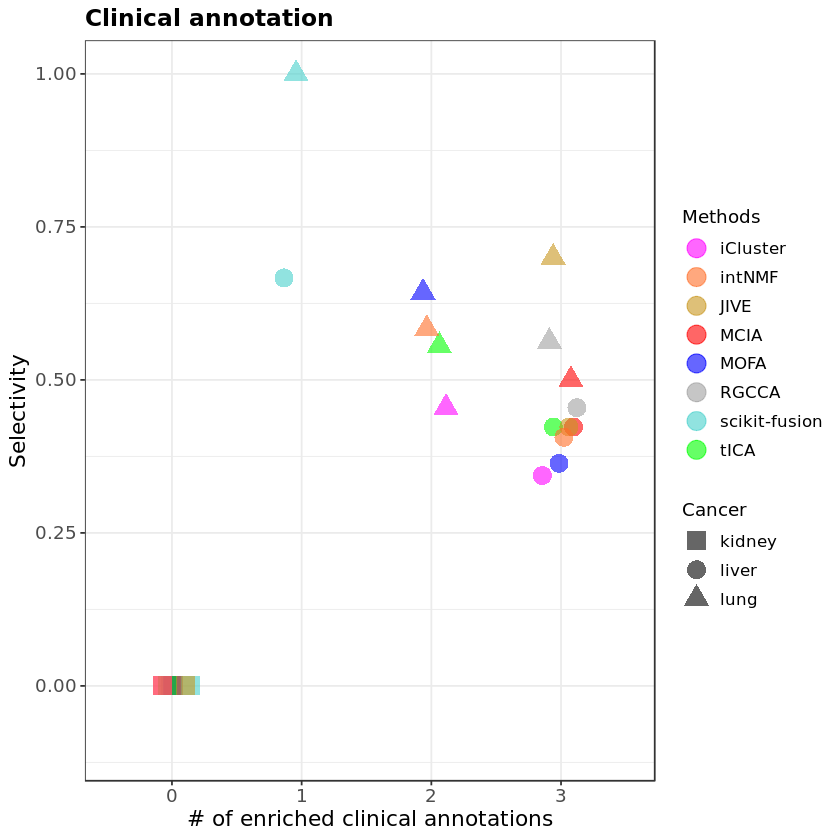

In [25]:
#cliAnn_fig2
cliAnn_dta <- cliAnn[cliAnn$cancer=="lung"| cliAnn$cancer=="kidney"|cliAnn$cancer=="liver",];
#tiff("cliAnn_fig2.tiff", units="in", width=8.95, height=6.05, res=300)
gCli <- ggplot(cliAnn_dta,
             aes(x=total_pathways,y=selectivity))+ geom_point(aes(colour = methods, shape = cancer),size=5,
                                                              alpha=.6,position=position_jitter(h=0, w=0.15))+ theme_bw() + scale_shape_manual(values=c(15,16,17))+ 
  scale_color_manual(values=c('#FF00FF','#FF6E28', '#C8961E', '#FF0000','#0000FF','#A0A0A0','#48D1CC','#00FF00'))+
  ylim(floor(min((cliAnn_dta[,"selectivity"]*10)-.4))/10,ceiling(max(cliAnn_dta[,"selectivity"]*10))/10)+
  labs(title="Clinical annotation", x="# of enriched clinical annotations")+
  theme(plot.title = element_text(size=14,face="bold"),axis.text = element_text(size=11),axis.title = element_text(size=13),legend.text=element_text(size=10))+
  ylab("Selectivity")+labs(colour = "Methods",shape="Cancer")+
  guides(color = guide_legend(order = 1),shape = guide_legend(order = 2),size = guide_legend(order = 3));

min_nonZero = min(cliAnn[cliAnn$cancer=="lung"| cliAnn$cancer=="kidney"|cliAnn$cancer=="liver","total_pathways"]) 
max_nonZero = max(cliAnn[cliAnn$cancer=="lung"| cliAnn$cancer=="kidney"|cliAnn$cancer=="liver","total_pathways"]) 
gCli <- gCli + scale_x_discrete()
gCli <- gCli + scale_x_discrete(limits=min_nonZero :max_nonZero)
gCli <- gCli + scale_x_discrete(limits=min_nonZero :max_nonZero, labels = c(min_nonZero :max_nonZero));
gCli
#dev.off()

ggsave("cliAnn_fig2.pdf",dpi=300)
ggsave("cliAnn_fig2.png",dpi=300)  

#### Figure 3

Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.
Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image


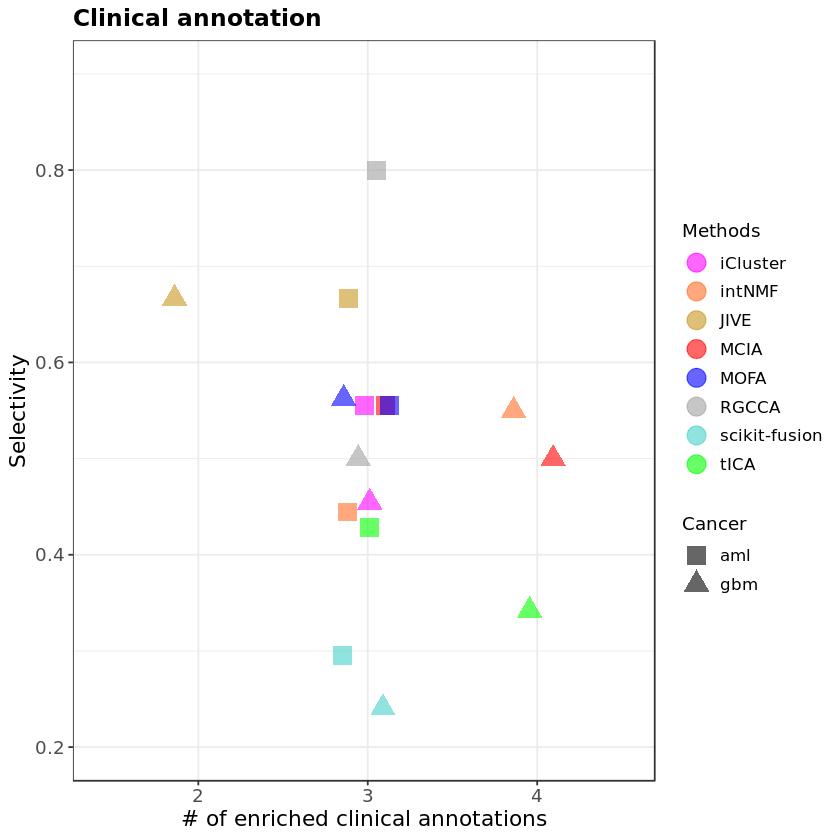

In [26]:
#cliAnn_fig3
cliAnn_dta <- cliAnn[cliAnn$cancer=="aml"| cliAnn$cancer=="gbm",];
#tiff("cliAnn_fig3.tiff", units="in", width=8.95, height=6.05, res=300)
gCli <- ggplot(cliAnn_dta,
             aes(x=total_pathways,y=selectivity))+ geom_point(aes(colour = methods, shape = cancer),size=5,
                                                              alpha=.6,position=position_jitter(h=0, w=0.15))+ theme_bw() + scale_shape_manual(values=c(15,17,3))+ 
  scale_color_manual(values=c('#FF00FF','#FF6E28', '#C8961E', '#FF0000','#0000FF','#A0A0A0','#48D1CC','#00FF00'))+
  ylim(floor(min((cliAnn_dta[,"selectivity"]*10)-.4))/10,ceiling(max((cliAnn_dta[,"selectivity"]*10)+.2))/10)+
  labs(title="Clinical annotation", x="# of enriched clinical annotations")+
  theme(plot.title = element_text(size=14,face="bold"),axis.text = element_text(size=11),axis.title = element_text(size=13),legend.text=element_text(size=10))+
  ylab("Selectivity")+labs(colour = "Methods",shape="Cancer")+
  guides(color = guide_legend(order = 1),shape = guide_legend(order = 2),size = guide_legend(order = 3));   

min_nonZero = min(cliAnn[cliAnn$cancer=="aml"| cliAnn$cancer=="gbm","total_pathways"]) 
max_nonZero = max(cliAnn[cliAnn$cancer=="aml"| cliAnn$cancer=="gbm","total_pathways"]) 
gCli <- gCli + scale_x_discrete()
gCli <- gCli + scale_x_discrete(limits=min_nonZero :max_nonZero)
gCli <- gCli + scale_x_discrete(limits=min_nonZero :max_nonZero, labels = c(min_nonZero :max_nonZero));
gCli
#dev.off()

ggsave("cliAnn_fig3.pdf",dpi=300)
ggsave("cliAnn_fig3.png",dpi=300)  

#### Figure 4

Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.
Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image


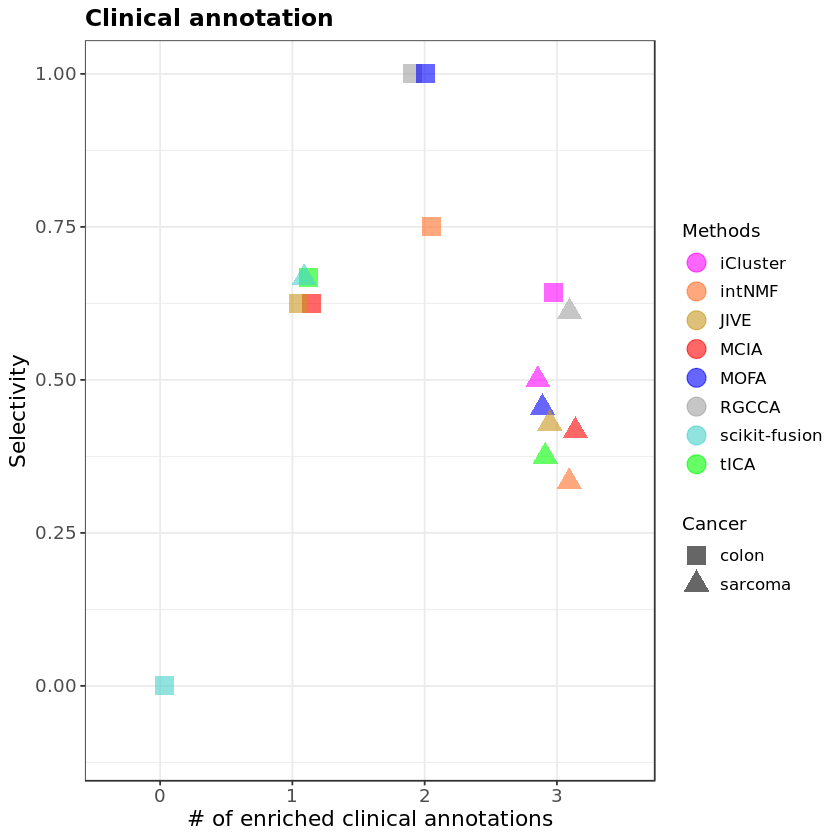

In [27]:
#cliAnn_fig4
cliAnn_dta <- cliAnn[cliAnn$cancer=="colon"| cliAnn$cancer=="sarcoma",];
#tiff("cliAnn_fig4.tiff", units="in", width=8.95, height=6.05, res=300)
gCli <- ggplot(cliAnn_dta,
             aes(x=total_pathways,y=selectivity))+ geom_point(aes(colour = methods, shape = cancer),size=5,
                                                              alpha=.6,position=position_jitter(h=0, w=0.15))+ theme_bw() + scale_shape_manual(values=c(15,17,3))+ 
  scale_color_manual(values=c('#FF00FF','#FF6E28', '#C8961E', '#FF0000','#0000FF','#A0A0A0','#48D1CC','#00FF00'))+
  ylim(floor(min((cliAnn_dta[,"selectivity"]*10)-.4))/10,ceiling(max(cliAnn_dta[,"selectivity"]*10))/10)+
  labs(title="Clinical annotation", x="# of enriched clinical annotations")+
  theme(plot.title = element_text(size=14,face="bold"),axis.text = element_text(size=11),axis.title = element_text(size=13),legend.text=element_text(size=10))+
  ylab("Selectivity")+labs(colour = "Methods",shape="Cancer")+ ## of factors enriched \n in at least one \n clinical annotation
  guides(color = guide_legend(order = 1),shape = guide_legend(order = 2),size = guide_legend(order = 3));   

min_nonZero = min(cliAnn[cliAnn$cancer=="colon"| cliAnn$cancer=="sarcoma","total_pathways"]) 
max_nonZero = max(cliAnn[cliAnn$cancer=="colon"| cliAnn$cancer=="sarcoma","total_pathways"]) 
gCli <- gCli + scale_x_discrete()
gCli <- gCli + scale_x_discrete(limits=min_nonZero :max_nonZero)
gCli <- gCli + scale_x_discrete(limits=min_nonZero :max_nonZero, labels = c(min_nonZero :max_nonZero));    
gCli
#dev.off()

ggsave("cliAnn_fig4.pdf",dpi=300)
ggsave("cliAnn_fig4.png",dpi=300)  